In [1]:
# A notebook for training a policy based agent using episodes playing a virtual game
import sys, random, os, math, time, itertools
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../app')
from config import Config

%matplotlib inline

In [2]:
class Policy:
    def __init__(self):
        self.high_level_actions = [
            'wait', #if stunned
            'random', #a valid strategy
           'go_opponent_flag',  #go get the flag
           'go_team_flag_area',  #especially if you have the flag
           'go_opponent_flag_carrier', #tag flag carrier
           'go_nearest_opponent', #chase
           'go_nearest_teammate', #a good choice if you have the flag
           'go_nearest_incapacitated_teammate', #revive them
           'gaurd_nearest_teammate',  #get between nearest teammate and enemy
           'gaurd_teammate_flag_carrier', #get between flag carrying teammate and enemy
           'gaurd_team_flag_area', #get between flag area and enemy
           'guard_opponent_flag_area',  #especially if opponent is running the flag
           'run_away_from_nearest_opponent',  #if being chased
           'run_away_from_opponents_centroid' #allows skirting dangerous areas
          ]
        
        self.high_level_states = ['opponents_flag_in_play', 
                                  'team_flag_in_play', 
                                  'self_incapacitated', 
                                  'self_has_flag', 
                                  'self_in_enemy_territory',
                                  'nearest_teammate_has_flag',
                                  'nearest_teammate_incapacitated', 
                                  'nearest_opponent_has_flag',
                                  'nearest_opponent_incapacitated'
                                 ]
        
        self.high_level_state_codes = [tuple([int(s) for s in seq]) for seq in itertools.product('01', repeat=len(self.high_level_states))]
        
        self.q = np.zeros((len(self.high_level_state_codes), len(self.high_level_actions)))
        
        
    def get_high_level_action(self, player, the_map):
        '''Get a high level action for the player based on high level percepts'''
        #this should only be called for live players, not incapacitated players, but we'll check
        if player.is_incapacitated:
            return 'wait'
        
        #Create high level state from percept derived from player and map state
        high_level_state = self.get_high_level_state(player, the_map)
        state_idx = self.high_level_state_codes.index(high_level_state)
        
        #select best action with probability proportional to utility
        action_utilities = {}
        
        #hla = high level action
        for hla in self.get_available_hlas(player, the_map, high_level_state):
            action_idx = self.high_level_actions.index(hla)
            value = self.q[state_idx, action_idx]
            action_utilities[hla] = value
        
        actions = [k for k in action_utilities.keys()]
        scale = sum(action_utilities.values())
        probs = [v/scale for v in action_utilities.values()]
        
        idx = np.random.choice(len(actions), p=probs)
        
        return actions[idx]
    
    
    def get_high_level_state(self, player, the_map):
        '''Determine which high level state applies at this time'''
        state = [0 for i in range(len(self.high_level_states))]
              
        if (player.team=='blue' and the_map.red_flag_in_play) or (player.team=='red' and the_map.blue_flag_in_play):
            state[self.high_level_states.index('opponents_flag_in_play')] = 1
        if (player.team=='blue' and the_map.blue_flag_in_play) or (player.team=='red' and the_map.red_flag_in_play):
            state[self.high_level_states.index('team_flag_in_play')] = 1
        if player.is_incapacitated:
            state[self.high_level_states.index('self_incapacitated')] = 1
        if player.has_flag:
            state[self.high_level_states.index('self_has_flag')] = 1
        if player.in_enemy_territory:
            state[self.high_level_states.index('self_in_enemy_territory')] = 1
            
        teammate_player = the_map.get_closest_player_by_team(player, player.team)
        if teammate_player.has_flag:
            state[self.high_level_states.index('nearest_teammate_has_flag')] = 1
        if teammate_player.is_incapacitated:
            state[self.high_level_states.index('nearest_teammate_incapacitated')] = 1
        
        opponent_player = the_map.get_closest_player_by_team(player, 'red' if player.team=='blue' else 'blue')
        if opponent_player.has_flag:
            state[self.high_level_states.index('nearest_opponent_has_flag')] = 1
        if opponent_player.is_incapacitated:
            state[self.high_level_states.index('nearest_opponent_incapacitated')] = 1
            
        return tuple(state)
            
        
    def get_available_hlas(self, player, the_map, high_level_state):
        '''Determine possible high level actions given the high level state'''
        #almost all hlas are possible except the two dependent on the flag being carried
        if player.is_incapacitated:
            return ['wait']
        
        hlas = self.high_level_actions.copy()
        hlas.remove('go_opponent_flag_carrier')
        hlas.remove('gaurd_teammate_flag_carrier')
        hlas.remove('go_nearest_incapacitated_teammate')
        
        if (player.team=='blue' and the_map.blue_flag_in_play) or (player.team=='red' and not the_map.red_flag_in_play):
            hlas.append('go_opponent_flag_carrier')
        if (player.team=='blue' and the_map.red_flag_in_play) or (player.team=='red' and not the_map.blue_flag_in_play):
            hlas.append('gaurd_teammate_flag_carrier')
        if high_level_state[self.high_level_states.index('nearest_teammate_incapacitated')]==1:
            hlas.append('go_nearest_incapacitated_teammate')
            
        return hlas

In [3]:
class VirtualMap():
    def __init__(self, config):
        self.players = []
        
        self.tile_speeds = np.load(config.map_default_speed_array)
        idx = np.where(self.tile_speeds==0)
        self.not_allowed = list(zip(idx[0].tolist(), idx[1].tolist()))
        self.middle_tile = self.tile_speeds.shape[1]//2
        
        #flags
        blue_flag_x = 5
        col_speeds = self.tile_speeds[:, blue_flag_x]
        idx = np.where(col_speeds > 0)[0].tolist()
        blue_flag_y = random.choice(idx[2:-2])
        self.blue_flag_xy = (blue_flag_x, blue_flag_y)
        
        red_flag_x = self.tile_speeds.shape[1] - blue_flag_x
        col_speeds = self.tile_speeds[:, red_flag_x]
        idx = np.where(col_speeds > 0)[0].tolist()
        red_flag_y = random.choice(idx[2:-2])
        self.red_flag_xy = (red_flag_x, red_flag_y)
        
        self.blue_flag_area = [(x,y) for x in range(self.blue_flag_xy[0]-2, self.blue_flag_xy[0]+3) for y in range(self.blue_flag_xy[1]-2, self.blue_flag_xy[1]+3)]
        self.red_flag_area = [(x,y) for x in range(self.red_flag_xy[0]-2, self.red_flag_xy[0]+3) for y in range(self.red_flag_xy[1]-2, self.red_flag_xy[1]+3)]
        self.blue_flag_in_play = False
        self.red_flag_in_play = False
        
        
    def get_closest_player_by_team(self, player, team):
        best_dist=float('inf')
        best_player = None
        x1, y1 = player.xy
        
        for other_player in self.players:
            if other_player.player_idx==player.player_idx or not other_player.team==team:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player = other_player
                
        return best_player
    
    
    def get_closest_player_to_xy_by_team(self, player, team):
        best_dist=float('inf')
        best_player = None
        x1, y1 = player.xy
        for other_player in self.players:
            if other_player.player_idx==player.player_idx or not other_player.team==team:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player = other_player
                
        return best_player
    
    
    def get_closest_incapacitated_player_by_team(self, player, team):
        best_dist=float('inf')
        best_player = None
        x1, y1 = player.xy
        
        for other_player in self.players:
            if other_player.player_idx==player.player_idx or not other_player.team==team or not other_player.is_incapacitated:
                continue
                
            x2, y2 = other_player.xy
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist<best_dist:
                best_player = other_player
                
        return best_player
    
    
    #copied from Player
    def get_direction_to_xy(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        delta_x, delta_y = x2 - x1, y2 - y1
        if abs(delta_x)>abs(delta_y):
            return 'a' if delta_x<0 else 'd'
        else:
            return 'w' if delta_y<0 else 's'
        
        
    def get_direction_away_from(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        delta_x, delta_y = x1 - x2, y1 - y2
        if abs(delta_x)<abs(delta_y):
            return 'a' if delta_x<0 else 'd'
        else:
            return 'w' if delta_y<0 else 's'
        
        
    def go_between(self, xy1, xy2):
        x1,y1 = xy1
        x2,y2 = xy2
        midx, midy = x1 + ((x2 - x1)/2), y1 + ((y2 - y1)/2)
        return self.get_direction_to_xy(xy1, (midx, midy))
    
        
        
class VirtualPlayer():
    def __init__(self, team, idx, the_map, xy):
        self.team = team
        self.player_idx = idx
        self.the_map = the_map
        self.has_flag = False
        self.is_incapacitated = False
        self.incapacitated_countdown = 0
        self.in_enemy_territory = False
        self.in_flag_area = False
        self.xy = xy
        self.prev_dir = random.choice(['a','w','s','d'])
        #for penalties
        self.got_tagged = False
        self.got_tagged_with_flag = False
        self.teammate_got_flag = False
        self.opponent_got_flag = False
        self.lost = False
        self.won = False
        
        
class VirtualGame():
    def __init__(self, config):
        self.the_map = VirtualMap(config)
        team_size = config.blue_team_size
        
        #put players in the map
        side = self.the_map.tile_speeds.shape[1]//3
        for team in ['blue', 'red']:
            if team=='blue':
                idx = np.where(self.the_map.tile_speeds[:,:side]>0)
            else:
                idx = np.where(self.the_map.tile_speeds[:,(side*2):]>0)
                idx = (idx[0], idx[1] + np.ones_like(idx[1]) * (side*2))
            allowed_init_tiles = list(zip(idx[0].tolist(), idx[1].tolist()))
            random.shuffle(allowed_init_tiles)
        
            for i in range(team_size):
                y, x = allowed_init_tiles.pop()
                player = VirtualPlayer(team, i, self.the_map, (x, y))
                self.the_map.players.append(player)
                
        #rewards
        #movement reward is speed value - 5
        self.stationary_reward = -5
        
        self.got_tagged_reward = -10
        self.got_tagged_with_flag_reward = -50
        self.tagged_reward = 20
        self.tagged_flag_holder_reward = 50
        
        self.revived_teammate_reward = 15
        self.got_flag_reward = 50
        self.teammate_got_flag_reward = 30
        self.opponent_got_flag_reward = -30
        
        self.lost_reward = -200
        self.won_reward = 200
        
        
        
    def step(self, player, hla):
        #execute a game step for a player using high level action and policy
        opponent_team = 'red' if player.team=='blue' else 'blue'
        
        #apply any outstanding penalties caused by another player
        if player.got_tagged:
            player.got_tagged = False
            return self.got_tagged_reward, False
        elif player.got_tagged_with_flag:
            player.got_tagged_with_flag = False
            return self.got_tagged_with_flag_reward, False
        elif player.teammate_got_flag:
            player.teammate_got_flag = False
            return self.teammate_got_flag_reward, False
        elif player.opponent_got_flag:
            player.opponent_got_flag = False
            return self.opponent_got_flag_reward, False
        elif player.lost:
            return self.lost_reward, True
        elif player.won:
            return self.won_reward, True
        
        
        if player.is_incapacitated:
            player.incapacitated_countdown -= 1
            #is countdown over?
            if player.incapacitated_countdown<=0:
                player.is_incapacitated = False
            return self.stationary_reward, False
        
        
        action = self.__hla_to_direction(player, hla)
        
        #apply direction if possible
        player_x, player_y = player.xy
        new_xy = player.xy
        speed = 0
        #tile speeds is row by col, which equals y by x
        if action=='w' and (player_y-1, player_x) not in self.the_map.not_allowed:
            new_xy = (player_x, player_y-1)
            speed = self.the_map.tile_speeds[player_y-1, player_x]
        elif action=='s' and (player_y+1, player_x) not in self.the_map.not_allowed:
            new_xy = (player_x, player_y+1)
            speed = self.the_map.tile_speeds[player_y+1, player_x]
        elif action=='a' and (player_y, player_x-1) not in self.the_map.not_allowed:
            new_xy = (player_x-1, player_y)
            speed = self.the_map.tile_speeds[player_y, player_x-1]
        elif action=='d' and (player_y, player_x+1) not in self.the_map.not_allowed:
            new_xy = (player_x+1, player_y)
            speed = self.the_map.tile_speeds[player_y, player_x+1]
        
        
        #if the player didn't move
        if not speed:
            return self.stationary_reward, False
        
        
        #update position
        player.xy = new_xy
        if player.team=='blue':
            if player.xy[0]>self.the_map.middle_tile and not player.in_enemy_territory:
                player.in_enemy_territory=True
            elif player.xy[0]<self.the_map.middle_tile and player.in_enemy_territory:
                player.in_enemy_territory=False
        if player.team=='red':
            if player.xy[0]<self.the_map.middle_tile and not player.in_enemy_territory:
                player.in_enemy_territory=True
            elif player.xy[0]>self.the_map.middle_tile and player.in_enemy_territory:
                player.in_enemy_territory=False
                
        
        #player won
        if player.team=='blue' and player.has_flag and new_xy in self.the_map.blue_flag_area:
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.lost = True
                else:
                    other_player.won = True
            #add rewards for other players AFTER the end signal is sent in order to award/penalize all players
            return self.won_reward, True
        elif player.team=='red' and player.has_flag and new_xy in self.the_map.red_flag_area:
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.lost = True
                else:
                    other_player.won = True
            return self.won_reward, True
        
        
        #player got flag
        if new_xy==self.the_map.red_flag_xy and player.team=='blue' and not self.the_map.red_flag_in_play:
            player.has_flag = True
            self.the_map.red_flag_in_play = True
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.opponent_got_flag = True
                else:
                    other_player.teammate_got_flag = True
            return self.got_flag_reward, False
        
        if new_xy==self.the_map.blue_flag_xy and player.team=='red' and not self.the_map.blue_flag_in_play:
            player.has_flag = True
            self.the_map.blue_flag_in_play = True
            for other_player in self.the_map.players:
                if other_player.player_idx==player.player_idx:
                    continue
                if other_player.team==opponent_team:
                    other_player.opponent_got_flag = True
                else:
                    other_player.teammate_got_flag = True
            return self.got_flag_reward, False
        
        
        #player tagged someone
        for other_player in self.the_map.players:
            #skip self
            if other_player.player_idx==player.player_idx:
                continue
                
            if not other_player.xy==new_xy:
                continue
                
            if other_player.team==opponent_team and not other_player.is_incapacitated and (other_player.in_enemy_territory or other_player.has_flag):
                other_player.is_incapacitated = True
                other_player.incapacitation_countdown = 5
                if other_player.has_flag:
                    other_player.has_flag = False
                    other_player.got_tagged_with_flag = True
                    if player.team=='blue':
                        self.the_map.red_flag_in_play = False
                    else:
                        self.the_map.blue_flag_in_play = False
                    return self.tagged_flag_holder_reward, False
                else:
                    other_player.got_tagged = True
                    return self.tagged_reward, False
            #revived teammate?
            elif other_player.team==player.team and other_player.is_incapacitated:
                other_player.is_incapacitated = False
                other_player.incapacitation_countdown = 0
                return self.revived_teammate_reward, False
            
        #player just moved
        return speed - 5, False
    
    
    #copied from policy agent
    def __hla_to_direction(self, player, hla):
        action = ''
        team = 'blue' if player.team=='blue' else 'red'
        opponent_team = 'red' if player.team=='blue' else 'blue'
        xy1 = player.xy
        
        if hla=='wait':
            return ''
        elif hla=='random':
            if random.randint(1,20) == 1:
                player.prev_dir = random.choice(['a','w','s','d'])
            action = player.prev_dir
        elif hla=='go_opponent_flag':
            xy2 = self.the_map.red_flag_xy if team=='blue' else self.the_map.blue_flag_xy
            action = self.the_map.get_direction_to_xy(xy1, xy2)
        elif hla=='go_team_flag_area':
            xy2 = self.the_map.blue_flag_xy if team=='blue' else self.the_map.red_flag_xy
            action = self.the_map.get_direction_to_xy(xy1, xy2)
        elif hla=='go_opponent_flag_carrier':
            for other_player in self.the_map.players:
                if not (other_player.team==opponent_team and other_player.has_flag):
                    continue
                action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
                break
        elif hla=='go_nearest_opponent':
            other_player = self.the_map.get_closest_player_by_team(player, opponent_team)
            action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
        elif hla=='go_nearest_teammate':
            other_player = self.the_map.get_closest_player_by_team(player, team)
            action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
        elif hla=='go_nearest_incapacitated_teammate':
            other_player = self.the_map.get_closest_incapacitated_player_by_team(player, team)
            action = self.the_map.get_direction_to_xy(xy1, other_player.xy)
        elif hla=='gaurd_nearest_teammate':
            other_player = self.the_map.get_closest_player_by_team(player, team)
            opponent_player = self.the_map.get_closest_player_to_xy_by_team(player, opponent_team)
            action = self.the_map.go_between(other_player.xy, opponent_player.xy)
        elif hla=='gaurd_teammate_flag_carrier':
            for other_player in self.the_map.players:
                if not (other_player.team==player.team and other_player.has_flag):
                    continue
                opponent_player = self.the_map.get_closest_player_to_xy_by_team(player, opponent_team)
                action = self.the_map.get_direction_to_xy(opponent_player.xy, other_player.xy)
                break
        elif hla=='gaurd_team_flag_area':
            xy2 = self.the_map.blue_flag_xy if team=='blue' else self.the_map.red_flag_xy
            other_player = self.the_map.get_closest_player_to_xy_by_team(player, opponent_team)
            action = self.the_map.go_between(other_player.xy, xy2)
        elif hla=='guard_opponent_flag_area':
            xy2 = self.the_map.red_flag_xy if team=='blue' else self.the_map.blue_flag_xy
            other_player = self.the_map.get_closest_player_to_xy_by_team(player, opponent_team)
            action = self.the_map.go_between(other_player.xy, xy2)
        elif hla=='run_away_from_nearest_opponent':
            other_player = self.the_map.get_closest_player_by_team(player, opponent_team)
            action = self.the_map.get_direction_away_from(xy1, other_player.xy)
        elif hla=='run_away_from_opponents_centroid':
            xs, ys = [],[]
            for other_player in self.the_map.players:
                if not other_player.team==opponent_team:
                    continue
                xs.append(other_player.xy[0])
                ys.append(other_player.xy[1])
            mean_xy = (sum(xs)/len(xs), sum(ys)/len(ys))
            action = self.the_map.get_direction_away_from(xy1, mean_xy)
            
        return action

In [6]:
class PolicyTrainer():
    def __init__(self, policy, config):
        self.policy = policy
        self.config = config
        self.discount = 0.8
        self.alpha = 1.0
        self.episodes = 1000
        
        
    def train(self):
        deltas = []
        state_cts = {}
        
        #each episode
        for i in range(self.episodes):
            if i and i%10==0:
                print('episode', i)
                for j in range(len(self.policy.high_level_actions)):
                    print('%s\t\t\t%.4f' % (self.policy.high_level_actions[j], self.policy.q[0,j]))
                self.__plot(deltas)
                
            ep_deltas = []
            
            #create virtual game, map, and players
            game = VirtualGame(self.config)
            
            #when game is over, do one more pass over players, skipping the person who won the game and was rewarded
            game_over = False
            skip_team_idx = ()
            final_scores = False
            
            for j in range(2000): #cut game off after x steps
                random.shuffle(game.the_map.players)
                for player in game.the_map.players:
                    if game_over and skip_team_idx and skip_team_idx==(player.team, player.player_idx):
                        #flag that we're assigning final scores
                        final_scores = True
                        continue
                        
                    #get game state for this player
                    state = self.policy.get_high_level_state(player, game.the_map)
                
                    if not state in state_cts:
                        state_cts[state]=0
                    state_cts[state]+=1
                
                    #Start exploring actions: For each state, select any one among all possible actions for the current state (S).
                    action = random.choice(self.policy.get_available_hlas(player, game.the_map, state))

                    #execute the hla and get the immediate reward for the new state
                    reward, game_over = game.step(player, action)
                    
                    #Travel to the next state (S') as a result of that action (a).
                    new_state = self.policy.get_high_level_state(player, game.the_map)

                    #For all possible actions from the state (S') select the one with the highest Q-value.
                    best_action = ''
                    best_value = -float('inf')
                    for pos_action in self.policy.get_available_hlas(player, game.the_map, new_state):
                        new_state_idx = self.policy.high_level_state_codes.index(new_state)
                        pos_action_idx = self.policy.high_level_actions.index(pos_action)
                        value = self.policy.q[new_state_idx, pos_action_idx]
                        if value>best_value:
                            best_action = pos_action
                            best_value = value

                    #get previous Q value for computing delta
                    state_idx = self.policy.high_level_state_codes.index(state)
                    action_idx = self.policy.high_level_actions.index(action)
                    prev_val = self.policy.q[state_idx, action_idx]

                    #calculate the utility
                    utility = (1 - self.alpha)* prev_val + self.alpha*(reward + self.discount*best_value)
                    self.policy.q[state_idx, action_idx] = utility

                    #store the delta for plotting
                    ep_deltas.append(abs(self.policy.q[state_idx, action_idx] - prev_val))

                    #Set the next state as the current state.
                    state = new_state

                    #If goal state is reached, then end and repeat the process.
                    if game_over:
                        if not skip_team_idx:
                            skip_team_idx=(player.team, player.player_idx)
                            break
                
                #has the last pass to assign final scores occurred?
                if game_over and final_scores:
                    print('game completed at', j)
                    break
                    
            deltas.append(sum(ep_deltas)/len(ep_deltas))  
        
        print(len(state_cts))
        for st,ct in state_cts.items():
            print(st, ct)
        self.__plot(deltas)
        
        
    def __plot(self, x, path=''):
        fig, ax = plt.subplots()
        ax.plot(x)
        ax.set(xlabel='time', ylabel='q delta', title='Q Learning deltas')
        ax.grid()
        if path:
            fig.savefig(path)
        plt.show()

10 [18.11008589 25.11008589 22.11008589 25.88760736 18.0912289  22.11008589
 28.11008589  0.         28.11008589 18.88760736 28.86403613 18.11008589
 18.11008589 22.88760736]
wait			18.1101
random			25.1101
go_opponent_flag			22.1101
go_team_flag_area			25.8876
go_opponent_flag_carrier			18.0912
go_nearest_opponent			22.1101
go_nearest_teammate			28.1101
go_nearest_incapacitated_teammate			0.0000
gaurd_nearest_teammate			28.1101
gaurd_teammate_flag_carrier			18.8876
gaurd_team_flag_area			28.8640
guard_opponent_flag_area			18.1101
run_away_from_nearest_opponent			18.1101
run_away_from_opponents_centroid			22.8876


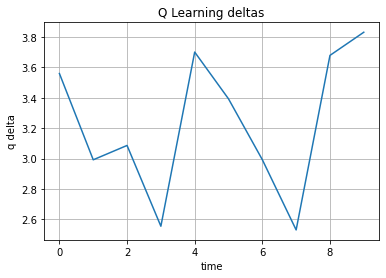

20 [14.8680586  24.99847882 24.99902644 21.99902644 14.99922116 18.99902644
 21.99093306  0.         21.99922116 14.99902644 24.98866632 21.99702894
 21.99922116 21.99702894]
wait			14.8681
random			24.9985
go_opponent_flag			24.9990
go_team_flag_area			21.9990
go_opponent_flag_carrier			14.9992
go_nearest_opponent			18.9990
go_nearest_teammate			21.9909
go_nearest_incapacitated_teammate			0.0000
gaurd_nearest_teammate			21.9992
gaurd_teammate_flag_carrier			14.9990
gaurd_team_flag_area			24.9887
guard_opponent_flag_area			21.9970
run_away_from_nearest_opponent			21.9992
run_away_from_opponents_centroid			21.9970


KeyboardInterrupt: 

In [7]:
trainer = PolicyTrainer(Policy(), Config())
trainer.train()

In [ ]:
 self.high_level_actions = [
            'wait', #if stunned
            'random', #a valid strategy
           'go_opponent_flag',  #go get the flag
           'go_team_flag_area',  #especially if you have the flag
           'go_opponent_flag_carrier', #tag flag carrier
           'go_nearest_opponent', #chase
           'go_nearest_teammate', #a good choice if you have the flag
           'go_nearest_incapacitated_teammate', #revive them
           'gaurd_nearest_teammate',  #get between nearest teammate and enemy
           'gaurd_teammate_flag_carrier', #get between flag carrying teammate and enemy
           'gaurd_team_flag_area', #get between flag area and enemy
           'guard_opponent_flag_area',  #especially if opponent is running the flag
           'run_away_from_nearest_opponent',  #if being chased
           'run_away_from_opponents_centroid' #allows skirting dangerous areas
          ]